# Tutorial 3 - Working with Seurat

## Load required packages

'Base' R's functionality can be extended by loading 'libraries' or 'packages' written by others. For this tutorial, we are featuring the Seurat library written by Rahul Satija's lab at the New York Genome Center.

In [1]:
# Similar to python, after installing the packages with "install.packages('name')" from Base R or
# "BiocManager::install('name') from Bioconductor they can be loaded with the "library(name) command"
library(dplyr)
library(Seurat)
library(useful)
library(RColorBrewer)
library(plotly)
library(here)
library(genieclust)
library(grid)
library(gridExtra)
library(matrixStats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


here() starts at /home/ktrav/BIOC281/Classes/3


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




In [2]:
# Check the location of the present working directoru
# This should be /home/<SUNetID>
here()

[1] "/home/ktrav/BIOC281/Classes/3"

## Data and metadata ingest

In [ ]:
# Read in metadata, which we downloaded as a comma separated values (CSV) table
# row.names=1 tells the read.csv command that the first column in the CSV contains the rownames
# By default, the first row is assumed to be the colnames (this can be overriden with header=FALSE)
#
# The here() command allows us to easily construct file paths. here('krasnow_hlca_10x_metadata.csv') 
# will evaluate to '/home/ktrav/BIOC281/Classes/3/krasnow_hlca_10x_metadata.csv'
meta_table <- read.csv(file = here('krasnow_hlca_10x_metadata.csv'), row.names = 1)

# The corner() command lets us look at the top left corner of the new meta_data variable
corner(meta_table, corner = "topleft")

In [ ]:
# Read in the table of UMIs detected of each gene for each cell
umi_table <- read.csv(file = here('krasnow_hlca_10x_UMIs.csv'), row.names = 1)

# Specific columns and rows from data frames (R speak for tables) can be accessed or subset
# with the syntax "table[rows, columns]". meta_table['P2_1_AACACGTTCGATCCCT','nGene']
# will evaluate to 1185, while meta_table[,'nGene'] will return a every cells' gene count
#
# Columns from a data frame can also be accessed with a "$" followed by their name
# meta_table$patient will return a vector of each cell's patient ID (1, 2 or 3)
#
# Operators (greater than, equal to, or less than) can be used to select the rows from specific
# patients. meta_table$patient == 1 will return a vector with TRUE for all cells from the 
# first patient and FALSE for all others. These TRUE/FALSE vectors (known as booleans) 
# can be passed into the table[rows, columns] format to select specific rows or columns
# Create two new dataframes that contain the UMIs and metadata for cells from the first patient
# Metadata usually has cells as rows, while UMI tables usually have cells as columns
umi_table_1 <- umi_table[,rownames(meta_table[meta_table$patient == 1,])]
meta_table_1 <- meta_table[colnames(umi_table_1),]

# Again we use the corner() command to check the first three rows and columns
# Note the cells all start with "P1", indicating they came from the first patient
corner(umi_table_1, r = 3, c = 3)

In [ ]:
# Create the Seurat object and associate the metadata
tiss <- CreateSeuratObject(counts = umi_table_1, project = "BIOC 281")
tiss <- AddMetaData(tiss, meta_table_1)

In [ ]:
# Individual R objects can be saved to the disk and read in later in "RDS" format
# Reading in an RDS of a Seurat object, which stores the UMI table as a sparse matrix (excludes 0s)
# is substantially faster than reading in a "dense" CSV
# Write the Seurat object to an RDS file
saveRDS(tiss, file = here('krasnow_hlca_10x_raw.rds'))

In [2]:
# Uncomment and execute second line if you need to reset the object
# Useful as read.csv is slow
#tiss = readRDS(file = "krasnow_hlca_10x_raw.rds")

## Explore the Seurat object

In [ ]:
# The Seurat object organizes many peices of information (such as the metadata and UMI table) onto
# different shelves that can be accessed with an "@" followed by their name. Hitting TAB after typing
# "tiss@" will reveal the different shelves inside, we demonstrate how to access important ones below.
tiss

In [ ]:
# The head() function, similar to corner(), can be used to show parts of a vector
# Current identities for all cells are found in tiss@active.ident, and we're using head() to show 5
head(tiss@active.ident, 5)

In [ ]:
# Top left corner of the metadata
corner(tiss@meta.data)

In [ ]:
# Pull specific piece of metadata from the first 5 cells
tiss@meta.data$nGene[1:5]

In [ ]:
# UMI table
tiss@assays$RNA

In [ ]:
# UMIs of specific genes from the first 5 cells
tiss@assays$RNA@counts[c('ACTB', 'UBB'), 1:5]

## Basic quality control

Low quality cells are usually excluded from analysis on the basis of having few reads/UMIs or genes detected. Some also exclude cells that have a high percentage of reads/UMIs mapping to ribosomal or mitochrondrial genes. Still others exclude cells that lack expression of "housekeeping genes" such as those in Tirosh et al (2016) _Science_

In [ ]:
# Sets the size of the plot below
options(repr.plot.width=12, repr.plot.height=6)

# Violin plots show the distribution of the number of genes, UMIs, and ribosomal percentage across cells
VlnPlot(tiss, features = c("nGene", "nUMI", 'percent.ribo'), ncol = 3, pt.size = 0.01)

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
QC1 <- FeatureScatter(tiss, feature1 = "nUMI", feature2 = "percent.ribo")
QC2 <- FeatureScatter(tiss, feature1 = "nUMI", feature2 = "nGene")
QC1 + QC2

**Question:** What is the relationship between the number of UMIs detected in a cell and its number of detected genes or percentage of ribosomal UMIs? Is this expected?

**Answer:**

In [3]:
# Carry forward only cells with 500 genes AND 1000 UMIs using the subset() command
tiss <- subset(tiss, subset = nGene > 500 & nUMI > 1000)

## Data normalization

In [4]:
# Convert UMIs to UMIs per 10K and then takes the natural log of all values plus 1
# 10K was chosen as a scaling factor to give similar values to counts based approaches
# These give expression as counts per million. Counts are necessarily greater than or equal to UMIs
tiss <- NormalizeData(tiss, scale.factor = 10000)

## Feature selection

Grouping cells based on their entire gene expression matrix is difficult because of the curse of dimensionality. To help, most groups usually start by selecting genes that have high expression and variance and then running principle component analysis (PCA).

When using repel, set xnudge and ynudge to 0 for optimal results

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


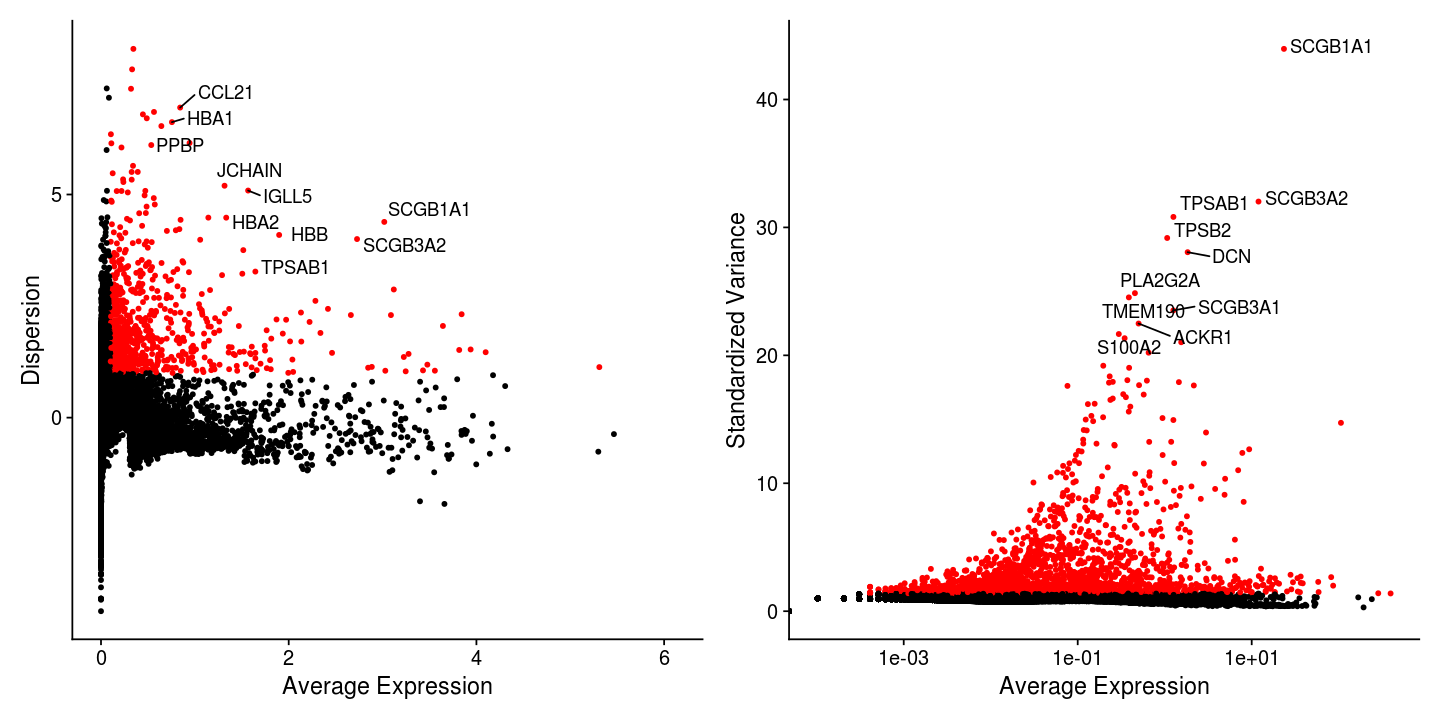

In [5]:
options(repr.plot.width=12, repr.plot.height=6)

# Identify the top 2,000 genes with the highest variance and expression
tiss <- FindVariableFeatures(tiss, selection.method = "mean.var.plot", nfeatures = 2000)

# Visualize the selected genes
MV <- VariableFeaturePlot(tiss) + theme(legend.position = 'none')
MV <- LabelPoints(plot = MV, points = head(VariableFeatures(tiss), 10), repel = TRUE)

# Identify the top 2,000 genes with the highest "standardized" variance and expression
tiss <- FindVariableFeatures(tiss, selection.method = "vst", nfeatures = 2000)

# Visualize the selected genes
MV2 <- VariableFeaturePlot(tiss) + theme(legend.position = 'none')
MV2 <- LabelPoints(plot = MV2, points = head(VariableFeatures(tiss), 10), repel = TRUE)

# Compare the genes selected, side by side
MV + MV2

**Note:** There are differences in the genes that are selected when using true versus standardized variances. Principle component analysis (run below) will use the genes from the last FindVariableGenes call (currently "vst").

## Linear dimensionality reduction

Principal component analysis (PCA) is a mathematical procedure that transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components. Principle components are vectors where each gene has a "loading". High or low loadings indicate genes that "define" the axis of variation a paticular principle component captures. Cells are "scored" by how they fall on that axis based on their expression of the defining genes.

In [6]:
# In order to run principle component analysis, the normalized expression matrix needs to be 
# centered (subtract the mean expression of each gene from each cells individual value)
# and scaled (divide the centered expression values by the standard deviation of each gene)
# This effectively turns expression values into z-scores
tiss <- ScaleData(tiss, features = rownames(tiss))

Centering and scaling data matrix



In [7]:
# Perform principle component analysis to identify major axes of variation
tiss <- RunPCA(tiss, features = VariableFeatures(object = tiss), npcs = 100)

PC_ 1 
Positive:  AGR3, SMIM22, WFDC2, AGR2, FXYD3, EPCAM, ELF3, KRT8, SLPI, DMKN 
	   CRNDE, CLDN3, TSPAN1, CKB, MUC1, SFTA3, CXCL17, SLC44A4, SLC34A2, SFTA2 
	   SFTPB, CAPS, MAL2, CYP4B1, TPPP3, C9orf24, PIGR, KRT18, TMEM190, SELENBP1 
Negative:  S100A4, TYROBP, CD52, FCER1G, CYBA, SPI1, MS4A7, CD68, ALOX5AP, LYZ 
	   IFI30, HLA-DQA1, MCEMP1, MRC1, MARCO, C1QC, OLR1, C1QA, ACP5, MS4A4A 
	   ALOX5, VSIG4, RETN, CTSS, C1QB, HLA-DQB1, FCGR3A, MSR1, FABP4, APOC1 
PC_ 2 
Positive:  SERPINA1, FTL, FTH1, FABP5, LGALS3, APOC1, C1QB, CRIP1, C1QA, C1QC 
	   S100A11, FBP1, MARCO, CSTB, MCEMP1, ACP5, FABP4, IFI30, CTSD, CAPG 
	   HLA-DQB1, TREM1, CD68, GCHFR, OLR1, MRC1, MS4A7, LGALS3BP, VSIG4, LYZ 
Negative:  IFITM1, TIMP3, RAMP2, GIMAP7, IL32, GNG11, CLEC14A, CLDN5, SPARCL1, CAV1 
	   TMEM100, SDPR, ITM2A, CLEC3B, C10orf10, RAMP3, HYAL2, NPDC1, TMEM204, ESAM 
	   IGFBP4, PTRF, PRSS23, LDB2, EGFL7, TNFSF10, FCN3, EDN1, CAV2, CALD1 
PC_ 3 
Positive:  PTPRCAP, NKG7, CST7, CCL5, GZMA, HBB, CD7, C

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

# Plot the standard deviation explained by each principle component
# Higher values indicate components that explain more variation in the UMI table
ElbowPlot(tiss, ndims = 100)

**Note:** the variance explained in the original matrix falls rapidly as you move through the principle components

In [ ]:
options(repr.plot.width=12, repr.plot.height=30)

# Show expression of the top and bottom 15 genes (based on loading) in each principle component
# from the 500 cells with the highest or lowest scores in that component
DimHeatmap(tiss, dims = 1:25, cells = 500, balanced = TRUE)

In [ ]:
options(repr.plot.width=12, repr.plot.height=30)

DimHeatmap(tiss, dims = 26:50, cells = 500, balanced = TRUE)

**Questions:** Do the genes along each principle component make sense? Are they defining axes between tissue compartments, cell types, or cell states (give examples)? What is the relationship between the standard deviation explained by each PC and the strength of its gene loadings?

**Answer:** 

## First round of clustering on the whole dataset

Seurat uses flavors of the Louvain algorithm to group cells. It uses a nearest neighbor map, created by calculating how close each cell is to all other cells are across some number of principle components.

In [ ]:
# Calculate nearest neighbor map
# FindNeighbors will use the first 10 principle compnents by default
# We will explore this further below
tiss <- FindNeighbors(tiss, verbose = FALSE)

# Find communities based on nearest neighbor map
tiss <- FindClusters(tiss, verbose = FALSE)

## Calculate two dimensional coordinates for all cells with UMAP

Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimension reduction technique that can be used for projecting high dimensionality data into 2 or more dimensions.

It is currently the most common way groups visualize scRNAseq data at cellular resolution.

See McInnes et al (2018) _ArXiv_ for more details

In [ ]:
# UMAP coordinates are typically calculated on some number of principle compnents
# There is no default, so we will stick with 10 for now
tiss <- RunUMAP(tiss, dims = 1:10, verbose = FALSE)

In [ ]:
options(repr.plot.width=12, repr.plot.height=12)

# Plot the UMAP coordinates for each cell and then color them by their cluster
DimPlot(tiss, reduction = "umap")

## Continue exploring the Seurat object with clustering completed

In [ ]:
# Details of commands run
names(tiss@commands)

In [ ]:
# Access the details of a specific command
tiss@commands$NormalizeData.RNA

In [ ]:
# UMI, ln(UP10K+1), scaled z-score tables
tiss@assays$RNA

In [ ]:
# ln(UP10K+1) of specific genes from the first 5 cells
tiss@assays$RNA@data[c('ACTB', 'UBB'), 1:5]

In [ ]:
# z-scores of specific genes from the first 5 cells
tiss@assays$RNA@scale.data[c('ACTB', 'UBB'), 1:5]

In [ ]:
# Results of dimensionality reductions
tiss@reductions

In [ ]:
# Access the coordinates of each cell across 5 principle components for the first 5 cells
corner(tiss@reductions$pca@cell.embeddings)

In [ ]:
# Access the gene loadings across the principle components for the first 10 genes
corner(tiss@reductions$pca@feature.loadings)

In [ ]:
# Nearest neighbor graph for the first 5 cells
tiss@graphs$RNA_nn[1:5,1:5]

In [ ]:
# Nearest neighbor weights for the first 5 cells
tiss@graphs$RNA_snn[1:5,1:5]

## Effect of varying principle components used for clustering

Mutual Information computes a similarity measure between two clusterings of the same data (see Romano et al (2016) Journal of Machine Learning Research). We can use the free annotations available in the dataset as a "ground truth" to benchmark the clustering while varying the number of principle compnents included. Higher AMIs (max is 1) mean more agreement between the two groupings.

In [ ]:
# How many clusters should there be?
length(unique(tiss@meta.data$free_annotation))

In [ ]:
# How many of each cell type are there? Sorted in descending order
sort(table(tiss@meta.data$free_annotation), decreasing = TRUE)

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

# Create a vector of components to test
# Will evaluate to [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
range_j = c(2, seq(from = 10, to = 100, by = 10))

# Create empty vectors to store adjusted mutual information (AMI) scores and cluster numbers
adjusted_mi_score_PCs <- c()
n_clusters_PCs <- c()

# Loop through each value in the vector range_j (created above)
for (j in 1:length(range_j)) {
        
        # Re-reun FindNeighbors and FindClusters with each principle compnent cutoff
        # e.g. 1:10 will return [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        tiss <- FindNeighbors(tiss, dims = 1:range_j[j], verbose = FALSE)
        tiss <- FindClusters(tiss, verbose = FALSE)
        
        # Save the rounded AMI and number of clusters
        # tiss@meta.data$seurat_clusters is where Seurat stores the results of FindClusters
        # tiss@meta.data$free_annotation contains the "ground truth annotations"
        # The adjusted_mi_score() function expects two numeric vectors
        # Seurats clusters are already numerics, but the free_annotations must be "coerced"
        # as.factor() gives each free annotation a number (based on alphanumeric order)
        # as.numeric() converts the vector to these numbers
        # The unique() function returns only the unique values in a vector
        # e.g. unique([1, 1, 1, 2, 2, 3]) will return [1, 2, 3]
        # So its length() tells us how many clusters there are
        adjusted_mi_score_PCs[j] <- round(adjusted_mi_score(tiss@meta.data$seurat_clusters, as.numeric(as.factor(tiss@meta.data$free_annotation))), 3)
        n_clusters_PCs[j] <- length(unique(tiss@meta.data$seurat_clusters))
}

# Associate each AMI and number of clusters with the number of principle compnents used
names(adjusted_mi_score_PCs) <- range_j
names(n_clusters_PCs) <- range_j

# Print and plot the AMIs and number of clusters
# The par() command allows us to plot two plots side by side
print('AMIs:')
print(adjusted_mi_score_PCs)
print(' ')
print('Cluster numbers:')
print(n_clusters_PCs)
par(mfrow=c(1,2))
plot(range_j,
     adjusted_mi_score_PCs,
     xlab ='Principle components used',
     ylab = 'Adjusted mutual information', 
     pch = 16)
plot(range_j,
     n_clusters_PCs,
     xlab ='Principle components used',
     ylab = 'Number of clusters', 
     pch = 16)
par(mfrow=c(1,1))

**Question:** Where does the AMI saturate? What about the number of clusters? How does that compare with the PC versus Standard Deviation plot above?

**Answer:**

## What about other clustering parameters?

There are two steps to clustering in Seurat, construction of a nearest neighborhor graph and then grouping the cells using flavors of the Louvain algorithm. There are two important parameters in finding nearest neighbors that can dramatically affect clustering:

**k.param:** The number of nearest neighbors to include in the graph

**prune.SNN:** Threshold to remove nearest neighbors that are not close enough

And one important for the louvain algorithm:

**resolution:** Sets the coarseness of clustering, lower numbers lead to fewer clusters and vice versa.

k.param and prune.SNN have similar effects on clustering, so we will only explore the pairwise effect of varying the k.param and resolution. The number of tunable parameters (including the number of principle components, and the selected features before that) are what make clustering more of an art than a science.

In [ ]:
# Set the optimal number of principle components to use from above
n_pcs = 50

# Create a vector of k.param and resolutions to test
range_j = c(0.25, seq(from = 0.5, to = 2, by = 0.5))
range_k = c(5, seq(from = 10, to = 50, by = 10))

# Create empty matrices to store adjusted mutual information (AMI) scores and cluster numbers
adjusted_mi_score_kreso <- matrix(0, nrow = length(range_j), ncol = length(range_k))
n_clusters_kreso <- matrix(0, nrow = length(range_j), ncol = length(range_k))

# Loop through all the resolutions to test
for (j in 1:length(range_j)) {
    
    # Loop through all the k.params to test
    for (k in 1:length(range_k)) {
                
        tiss <- FindNeighbors(tiss, dims = 1:n_pcs, k.param = range_k[k], verbose = FALSE)
        tiss <- FindClusters(tiss, resolution = range_j[j], verbose = FALSE)
        
        
        
        adjusted_mi_score_kreso[j,k] <- round(adjusted_mi_score(tiss@meta.data$seurat_clusters, as.numeric(as.factor(tiss@meta.data$free_annotation))), 3)
        n_clusters_kreso[j,k] <- length(unique(tiss@meta.data$seurat_clusters))
        
    }
    
}

rownames(adjusted_mi_score_kreso) <- range_j
colnames(adjusted_mi_score_kreso) <- range_k

rownames(n_clusters_kreso) <- range_j
colnames(n_clusters_kreso) <- range_k

print('AMIs:')
print(adjusted_mi_score_kreso)
print(" ")
print('Number of clusters:')
print(n_clusters_kreso)

**Note:** _Increasing_ the k.param _decreases_ the number of communities detected, while _increasing_ the resolution _increases_ the number of communities (both as expected)

**Question:** How does optimizing on a low number of PCs (e.g. 2) affect the AMIs and number of clusters?

**Answer:**

**Question:** How can decreasing the k.param or increasing the resolution increase the number of clusters, but not their agreement with the ground truth?

**Answer:**

## Re-run clustering with optimal paramters

In [8]:
# Set the optimal parameters
n_pcs = 50
k = 5
res = 0.5

tiss <- FindNeighbors(tiss, dims = 1:n_pcs, k.param = k, verbose = FALSE)
tiss <- FindClusters(tiss, resolution = res, verbose = FALSE)
tiss <- RunUMAP(tiss, dims = 1:n_pcs, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [9]:
# Write out optimized clusters for comparison with scanpy later
write.csv(tiss@meta.data[,"seurat_clusters",drop=FALSE], file = here('seurat_clusters.csv'))

In [12]:
# Print the AMI with the updated paramters
print(paste0(' AMI: ', round(adjusted_mi_score(tiss@meta.data$seurat_clusters, as.numeric(as.factor(tiss@meta.data$free_annotation))), 3)))

[1] " AMI: 0.851"


In [13]:
# Check which compartment has the lowest adjusted mutual information score
# Loop through and subset the seurat_clusters or free_annotations
# to include only the cells in each compartment
for (i in unique(tiss@meta.data$compartment)) {
    print(paste0(i,' AMI: ', round(adjusted_mi_score(tiss@meta.data$seurat_clusters[tiss@meta.data$compartment == i], as.numeric(as.factor(tiss@meta.data$free_annotation[tiss@meta.data$compartment == i]))), 3)))
}

[1] "Immune AMI: 0.775"
[1] "Epithelial AMI: 0.887"
[1] "Endothelial AMI: 0.824"
[1] "Stromal AMI: 0.675"


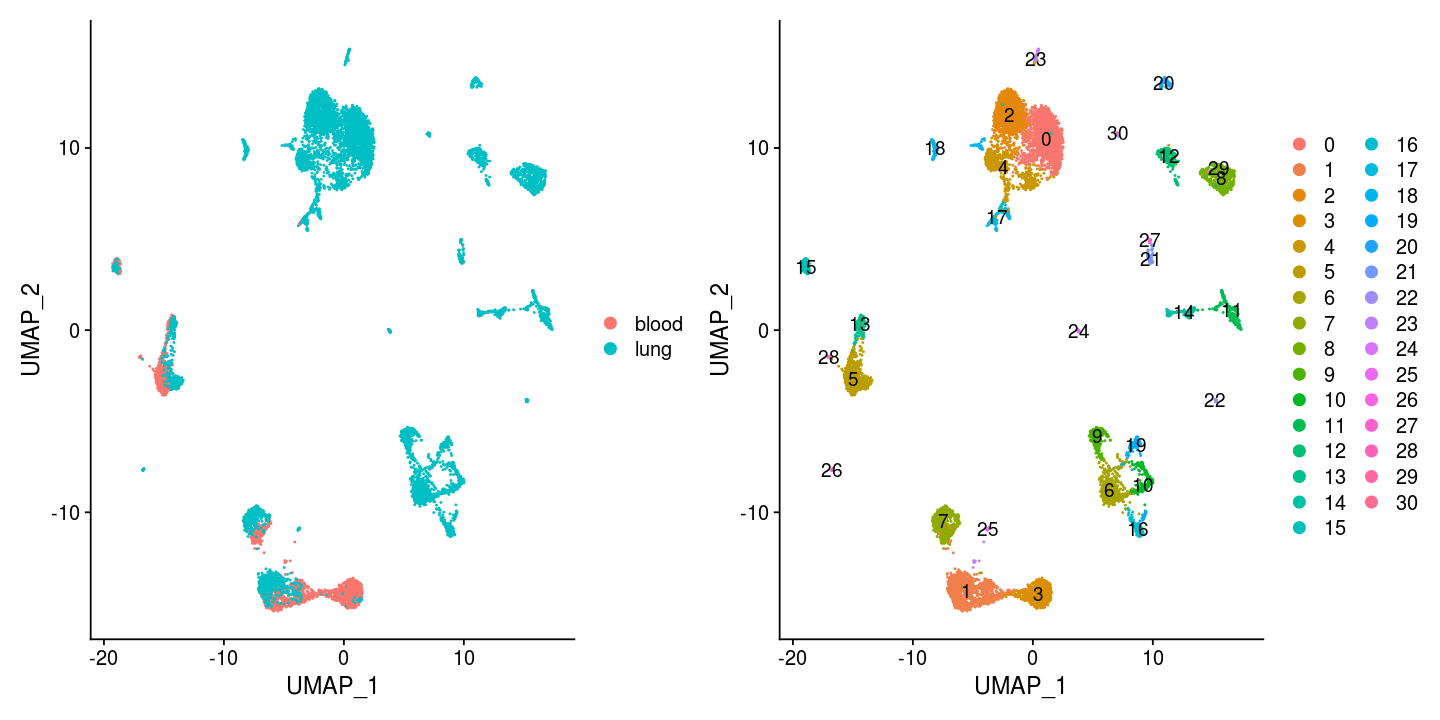

In [14]:
options(repr.plot.width=12, repr.plot.height=6)
# In addition to coloring the cells by cluster identity, you can also color them by other
# discrete metadata, such as the type of tissue each cell came from
DimPlot(tiss, reduction = "umap", group.by = "tissue") + DimPlot(tiss, reduction = "umap",label = TRUE)

In [ ]:
# Plot continuous meta data and expression of genes that mark common states
# and the gour major tissue compartments
options(repr.plot.width=12, repr.plot.height=20)
FeaturePlot(tiss, reduction = "umap",
            features = c("nGene", "percent.ribo", # Quality control
                         "MKI67", "TOP2A", # Proliferative
                         "EPCAM", # Epithelial
                         "CLDN5", # Endothelial
                         "COL1A2", # Stromal
                         "PTPRC"), # Immune
            cols = c('green', 'blue3'), 
            ncol = 2,
            pt.size = 0.25)


## Subset stromal cells to refine their clustering

Subsetting and re-running the Seurat pipline allows us to tune the number of features to take into principle component analysis, the number of components and k.param to use in constructing the nearest neighbor map, and the resolution to set the coarseness of louvain clustering to this specific set of transcriptionally similar stromal cells without worrying about the other major cell types.

In [7]:
# We can use the same subset command as above to separate stromal cells
# If the metadata did not include tissue compartments, you could subset based
# on Seurat clusters (e.g. subset(tiss, seurat_clusters %in% c(1, 2, 3)))
tiss_stromal <- subset(tiss, compartment == 'Stromal')
tiss_stromal

An object of class Seurat 
26485 features across 458 samples within 1 assay 
Active assay: RNA (26485 features, 0 variable features)

In [ ]:
# The dyplr package defines operators (%>%) that are useful for streaming the 
# Seurat object through several functions in one line, note how "object = tiss" is
# stated first and then omitted from each command
# Select variable genes, center and scale them, and then run PCA
tiss_stromal <- tiss_stromal %>% FindVariableFeatures(selection.method = "vst", nfeatures = 2000, verbose = FALSE) %>%
        ScaleData(features = rownames(tiss_stromal), verbose = FALSE) %>%
        RunPCA(features = VariableFeatures(object = tiss_stromal))

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
MV <- VariableFeaturePlot(tiss_stromal) + theme(legend.position = 'none')
MV <- LabelPoints(plot = MV, points = head(VariableFeatures(tiss_stromal), 20), repel = TRUE)
MV

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
ElbowPlot(tiss_stromal, ndims = 50)

In [ ]:
options(repr.plot.width=12, repr.plot.height=30)
DimHeatmap(tiss_stromal, dims = 1:25, cells = 250, balanced = TRUE)

In [ ]:
# Create nearest neighbor map, cluster the data
# and then project the cells into 2 dimensions with UMAP
tiss_stromal <- tiss_stromal %>% FindNeighbors(dims = 1:18, k.param = 20, verbose = FALSE) %>% 
            FindClusters(verbose = FALSE, resolution = 0.9) %>%
            RunUMAP(d ims = 1:18, verbose = FALSE)

In [ ]:
# Print the AMI for the clustering compared to the ground truth
print(paste0("AMI: ", round(adjusted_mi_score(tiss_stromal@meta.data$seurat_clusters, as.numeric(as.factor(tiss_stromal@meta.data$free_annotation))), 3)))

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)
# Plot the subsetted stromal cells in their new UMAP coordinates and color by
# the ground truth annotations and the seurat clusters
DimPlot(tiss_stromal, reduction = "umap", group.by = c("free_annotation"), label = TRUE, repel = TRUE) + theme(legend.position = 'none') +
    DimPlot(tiss_stromal, reduction = "umap", group.by = c("seurat_clusters"))

**Note:** We used specific parameters (n_pcs = 18, k = 20, res = 0.9) to obtain clusters that roughly match the ground truth. We were able to optimize them and improve the AMI for stromal cells because we simplified the problem. The ground truth annotations come from in situ hybridization experiments for the markers provided below.

**Question:** How does varying the parameters chosen affect the AMI?

**Answer:**

In [ ]:
# Plot some basic meta data, common states, and marker genes
options(repr.plot.width=12, repr.plot.height=12)
FeaturePlot(tiss_stromal,
            reduction = "umap",
            pt.size = 0.25,
            features = c("nGene", "percent.ribo", # Basic QC
                         "COL1A2", "BGN", # Stromal markers
                         "ACTA2", "MYH11", # Contractile markers
                         "KCNA5", "DES", # Airway smooth muscle
                         "HIGD1B", "FAM105A", # Pericyte
                         "ASPN", 'TGFBI', # Myofibroblast
                         "SFRP2", "FBLN2", # Adventitial fibroblast
                         "GPC3", "FGFR4", # Alveolar fibroblast
                         "APOE", "MUM1L1", # Lipofibroblast
                         "UPK3B", "MSLN"), # Mesothelial cell
            cols = c('green', 'blue3'),
            ncol = 4)


In [ ]:
# Identify differentially expressed genes in each cluster compared to all other clusters
# p-values come from a wilcoxon rank sum test (others are available),with a bonferroni correction
all_markers <- FindAllMarkers(object = tiss_stromal, only.pos = TRUE)

In [ ]:
# Use dyplr to show top 5 genes in each cluster, sorted by adjusted p-value
all_markers %>% group_by(cluster) %>% top_n(-5, p_val_adj)

In [ ]:
options(repr.plot.width=12, repr.plot.height=16)
# Subset the top 4 markers for each cluster by adjusted p-value
genes_plot <- all_markers %>% group_by(cluster) %>% top_n(-4, p_val_adj)

# Plot their expression
FeaturePlot(tiss_stromal,
            reduction = "umap",
            pt.size = 0.25,
            features = genes_plot$gene,
            cols = c('green', 'blue3'),
            ncol = 4)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
# Map clusters to cell identities
# Clustering has some inherent randomness and you may need to change the order
new_cluster_ids <- c("Adventitial Fibroblast", # 0
                     "Airway Smooth Muscle", # 1
                     "Pericyte", # 2
                     "Alveolar Fibroblast", # 3
                     "Lipofibroblast", # 4
                     "Myofibroblast", # 5
                     "Mesothelial") # 6
names(new_cluster_ids) <- levels(tiss_stromal)
tiss_stromal <- RenameIdents(tiss_stromal, new_cluster_ids)
DimPlot(tiss_stromal, reduction = "umap", label = TRUE, pt.size = 0.5) + theme(legend.position = 'none')

In [ ]:
tmp <- cbind(as.character(tiss_stromal@active.ident), tiss_stromal@meta.data$free_annotation)
print(paste0('% correct: ', round(100 * length(which(tmp[,1] == tmp[,2])) / dim(tmp)[1], 1)))

## Integrate 10x and SS2 data using Seurat

Seurat has a method for integrating 2 or more datasets based on common axes of variation using Canonical Correlation Analysis (CCA)

In [40]:
# Read in SS2 metadata and data
meta_table <- read.csv(file = here('krasnow_hlca_facs_metadata.csv'), row.names = 1)
count_table <- read.csv(file = here('krasnow_hlca_facs_counts.csv'), row.names = 1)

# Subset both to include only data from patient 1
count_table_1 <- count_table[,rownames(meta_table[meta_table$patient == 1,])]
meta_table_1 <- meta_table[colnames(count_table_1),]

In [41]:
# A list can store any number of other objects in different shelves accessible with list[['shelf name']]
# We are using one here to store the Seurat objects from the 10x and SS2 datasets
# Create a list to hold the Seurat objects we want integrate
lung_list <- list()
lung_list[["10x"]] <- tiss

In [42]:
# Create the Seurat object and associate the metadata
lung_list[["SS2"]] <- CreateSeuratObject(counts = count_table_1, project = "BIOC 281")
lung_list[["SS2"]] <- AddMetaData(lung_list[["SS2"]], meta_table_1)
lung_list[["SS2"]]

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
58683 features across 3987 samples within 1 assay 
Active assay: RNA (58683 features, 0 variable features)

**Note:** The SS2 dataset has nearly 60K features (genes) compared with the 10x dataset's roughly 26K because they were aligned with different genome annotations. The SS2 dataset was aligned with the gencode annotation that includes non-coding RNAs, mitochondrial genes, and more, while the 10x dataset was aligned with RefSeq's, which does not. This is generally not recommended and will make integration more difficult

In [ ]:
# Write the Seurat object to an RDS file
saveRDS(lung_list[["SS2"]], file = here('krasnow_hlca_facs_raw.rds'))

In [23]:
# Uncomment and execute second line if you need to reset the object
# Useful as read.csv is slow
#lung_list[["SS2"]] = readRDS(file = "krasnow_hlca_facs_raw.rds")

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

# Create the same QC plots as above
VlnPlot(lung_list[["SS2"]], features = c("nGene", "nReads", 'percent.ribo'), ncol = 3, pt.size = 0.01)

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

QC1 <- FeatureScatter(lung_list[["SS2"]], feature1 = "nReads", feature2 = "percent.ribo")
QC2 <- FeatureScatter(lung_list[["SS2"]], feature1 = "nReads", feature2 = "nGene")
QC1 + QC2

**Question:** How does the relationship between the number of UMIs and genes detected in 10x data compare with reads in SS2?

**Answer:**

In [43]:
# Carry forward only cells with 500 genes AND 50000 reads using the subset() command
# Then normalize the counts per million (commonly used for counts based expression)
# Then find the highly variable genes as above
lung_list[["SS2"]] <- lung_list[["SS2"]] %>% subset(subset = nGene > 500 & nReads > 50000) %>%
                    NormalizeData(scale.factor = 1000000) %>%
                    FindVariableFeatures(selection.method = "vst", nfeatures = 2000, verbose = FALSE)

In [ ]:
# Run CCA to find the common axes of variation
anchors <- FindIntegrationAnchors(object.list = lung_list, dims = 1:30)

In [ ]:
# Create a new Seurat object with an both datasets, integrated on the axes defined in the previous step
lung_integrated <- IntegrateData(anchorset = anchors, dims = 1:30)

In [ ]:
# You can still access the original counts, normalized expression data, and scaled z-scores at 
# lung_integrated@assays$RNA@counts/data/scale.data, but you can also access the 'integrated' data
lung_integrated@assays$integrated@data[c('CLDN5', 'EPCAM'),1:5]

In [ ]:
# Set the "default" slot Seurat uses to the integrated data for future functions
# Also coerce two metadata columns to make later analyses easier
DefaultAssay(lung_integrated) <- "integrated"
lung_integrated@meta.data$compartment <- tolower(lung_integrated@meta.data$compartment)
lung_integrated@meta.data$orig.ident <- gsub('Human Lung', '', lung_integrated@meta.data$orig.ident)

# Run the standard workflow for clustering and visualization
lung_integrated <- lung_integrated %>% ScaleData(verbose = FALSE) %>%
                        RunPCA(verbose = FALSE) %>%
                        RunUMAP(reduction = "pca", dims = 1:30, verbose = FALSE)

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

# Plot the new UMAP coordinates and color by the capture technology
DimPlot(lung_integrated, reduction = "umap", group.by = c("orig.ident"))

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

# Plot the new UMAP coordinates and color by the ground truth annotations
DimPlot(lung_integrated, reduction = "umap", group.by = c("free_annotation"), label = TRUE, repel = TRUE) + theme(legend.position = 'none')

**Question:** What is the value to having similar UMAP coordinates for the two datasets?

**Answer:**

## Transfering the labels with CCA

In [ ]:
# Identify common axes of correlation as above and then ask Seurat
# to predict the SS2 annotations based on cells from the 10x dataset
anchors <- FindTransferAnchors(reference = lung_list[["10x"]], query = lung_list[["SS2"]], dims = 1:30)
predictions <- TransferData(anchorset = anchors, refdata = lung_list[["10x"]]@meta.data$free_annotation, dims = 1:30)

In [ ]:
# cbind() stiches together two vectors of matrices with the same length 
#
# Stich together the predicted and actual free annotation for each cell type
# and then calculate and print the percentage of them that match
tmp <- cbind(predictions$predicted.id, lung_list[["SS2"]]@meta.data$free_annotation)
print(paste0('Total % correct: ', round(100 * length(which(tmp[,1] == tmp[,2])) / dim(tmp)[1], 1)))

# merge() stiches together two matrices with the same or differing lengths by common information
# 
# Stich together the total number of cells of each type and the number misassigned 
# and then calculate and print the percentage of incorrectly called cells by type
tmp <- merge(as.matrix(table(lung_list[["SS2"]]@meta.data$free_annotation)),
      as.matrix(table(lung_list[["SS2"]]@meta.data$free_annotation[tmp[,1] != tmp[,2]])),
      by = "row.names",
      all.x = TRUE)
tmp[is.na(tmp)] <- 0
tmp[,4] <- round((tmp[,3] / tmp[,2]) * 100, 1)
rownames(tmp) <- tmp$Row.names
tmp[,c("Row.names", "V1.x", "V1.y")] <- NULL
colnames(tmp) <- "% Incorrect"
tmp[order(tmp[,1]),,drop=FALSE]

In [ ]:
# Print the number of cell types found in the 10x and SS2 datasets
as.matrix(table(lung_integrated@meta.data[,c('free_annotation', 'orig.ident')]))

**Question:** Looking carefully at Seurat's accuracy and what cell types exist in both datasets, why do you think it struggled and succeeded where it did?

**Answer:**

## Cluster integrated dataset

In [ ]:
# Cluster the combined dataset using the integrated expression values
lung_integrated <- lung_integrated %>% FindNeighbors(verbose = FALSE, dims = 1:50) %>%
                        FindClusters(verbose = FALSE)

In [ ]:
# Calculate the Adjusted Mutual Information (AMI) between the ground truth annotations and the integrated dataset clusters
print(paste0("AMI: ", round(adjusted_mi_score(lung_integrated@meta.data$seurat_clusters, as.numeric(as.factor(lung_integrated@meta.data$free_annotation))), 3)))

In [ ]:
# Split the AMI by compartment
for (i in unique(lung_integrated@meta.data$compartment)) {
    print(paste0(i,' AMI: ', round(adjusted_mi_score(lung_integrated@meta.data$seurat_clusters[lung_integrated@meta.data$compartment == i], as.numeric(as.factor(lung_integrated@meta.data$free_annotation[lung_integrated@meta.data$compartment == i]))), 3)))
}

**Note:** The louvain clustering algorithm again struggles with all of the data together, but its assignments could be cleaned up with compartment separation and/or iterative subclustering.

**Question:** Describe step by step how you would annotate a dataset that had 50,000 cells captured through both 10x (90% of cells) and SmartSeq2 (10% of cells) from 5 different human patients with the ground truth available for 1 patient?

**Answer:**